# Práctica 3: Trabajo Final

Docente: Gustavo Landfried
Inferencia Bayesiana Causal 1
1er cuatrimestre 2025
UNSAM

Alumno: Tomás Pablo Korenblit
*Estimación de desempeño de tests diagnósticos conociendo el estado de las muestras pero con datos falsificados o cargados con error.*

In [2]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.patches import FancyBboxPatch
import seaborn as sns

np.random.seed(16)

In [3]:
def draw_causal_graph(edge_list, graph_direction="TB", node_props=None, edge_props=None, figsize=(10, 8)):
    """Visualización del grafo causal usando networkx"""
    G = nx.DiGraph()
    G.add_edges_from(edge_list)

    if graph_direction in {"LR", "TB", "BT", "RL"}:
        pos = nx.nx_agraph.graphviz_layout(G, prog='dot', args=f'-Grankdir={graph_direction}')
    else:
        pos = nx.spring_layout(G, k=3, iterations=50)

    plt.figure(figsize=figsize)
    default_node_color = 'lightblue'
    default_node_size = 2000

    for node in G.nodes():
        color = node_props.get(node, {}).get('color', default_node_color) if node_props else default_node_color
        size = node_props.get(node, {}).get('size', default_node_size) if node_props else default_node_size
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color=color, node_size=size, alpha=0.8)

    nx.draw_networkx_edges(G, pos, edge_color='black', arrows=True, arrowsize=20, arrowstyle='->', width=2, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    if edge_props:
        edge_labels = {edge: props['label'] for edge, props in edge_props.items() if 'label' in props}
        if edge_labels:
            nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)

    plt.title("Modelo Causal - Tests Diagnósticos con Error de Operador", fontsize=16, fontweight='bold', pad=20)
    plt.axis('off')
    plt.tight_layout()
    return G, pos

In [4]:
# Carga y transformación de datos
df = pd.read_csv("positivos_por_tests.csv")
print("Datos originales:")
display(df.head())
print(f"\nDimensiones: {df.shape}")

Datos originales:


,Laboratorio,muestra,20par-DTU1,20par-DTU2,20par-DTU6,50par-DTU1,50par-DTU2,50par-DTU6
0,AS,3,66.666667,100.0,100.0,100.0,100,100.0
1,VH,3,100.000000,100.0,100.0,100.0,100,100.0
2,CB,3,100.000000,100.0,100.0,100.0,100,100.0
3,SC,3,100.000000,100.0,100.0,100.0,100,100.0
4,SU-1,3,33.333333,100.0,100.0,100.0,100,100.0



Dimensiones: (14, 8)


In [5]:
# Transformación a formato largo
df_long = pd.melt(df, id_vars=['Laboratorio', 'muestra'], var_name='Test_Concentracion', value_name='Porcentaje_Positivo')
df_long[['Concentracion', 'Test']] = df_long['Test_Concentracion'].str.split('-', expand=True)
df_long['Test'] = df_long['Test'].str.replace('DTU', 'DTU_')
df_long['Concentracion_num'] = df_long['Concentracion'].str.extract('(\d+)').astype(int)
df_long['Proporcion_Positiva'] = df_long['Porcentaje_Positivo'] / 100
df_long['n_muestras'] = 3
df_long['n_positivos'] = np.round(df_long['Proporcion_Positiva'] * df_long['n_muestras']).astype(int)

print("\nDatos transformados:")
display(df_long.head(10))


Datos transformados:


,Laboratorio,muestra,Test_Concentracion,Porcentaje_Positivo,Concentracion,Test,Concentracion_num,Proporcion_Positiva,n_muestras,n_positivos
0,AS,3,20par-DTU1,66.666667,20par,DTU_1,20,0.666667,3,2
1,VH,3,20par-DTU1,100.000000,20par,DTU_1,20,1.000000,3,3
2,CB,3,20par-DTU1,100.000000,20par,DTU_1,20,1.000000,3,3
3,SC,3,20par-DTU1,100.000000,20par,DTU_1,20,1.000000,3,3
4,SU-1,3,20par-DTU1,33.333333,20par,DTU_1,20,0.333333,3,1
5,SU-2,3,20par-DTU1,100.000000,20par,DTU_1,20,1.000000,3,3
6,TA-1,3,20par-DTU1,66.666667,20par,DTU_1,20,0.666667,3,2
7,TA-2,3,20par-DTU1,66.666667,20par,DTU_1,20,0.666667,3,2
8,YA-1,3,20par-DTU1,33.333333,20par,DTU_1,20,0.333333,3,1
9,YA-2,3,20par-DTU1,100.000000,20par,DTU_1,20,1.000000,3,3


### 3.1 Problema de investigación

El objetivo es desarrollar un modelo causal que incorpore la posibilidad de error en los operadores, demostrando diferencias significativas en el desempeño de los tres tests cuando la concentración del parásito es baja.

### 3.2 Modelo Causal

Variables del modelo:
- **C**: Concentración del parásito (20 o 50 par.Eq/ml)
- **T**: Tipo de test (DTU1, DTU2, DTU6)
- **L**: Laboratorio (competencia técnica)
- **S**: Sensibilidad real del test (latente)
- **E**: Error del operador (latente, binario)
- **Y**: Resultado observado (porcentaje de positivos)
- **V**: Estado verdadero = 1 (todas las muestras son positivas por diseño)

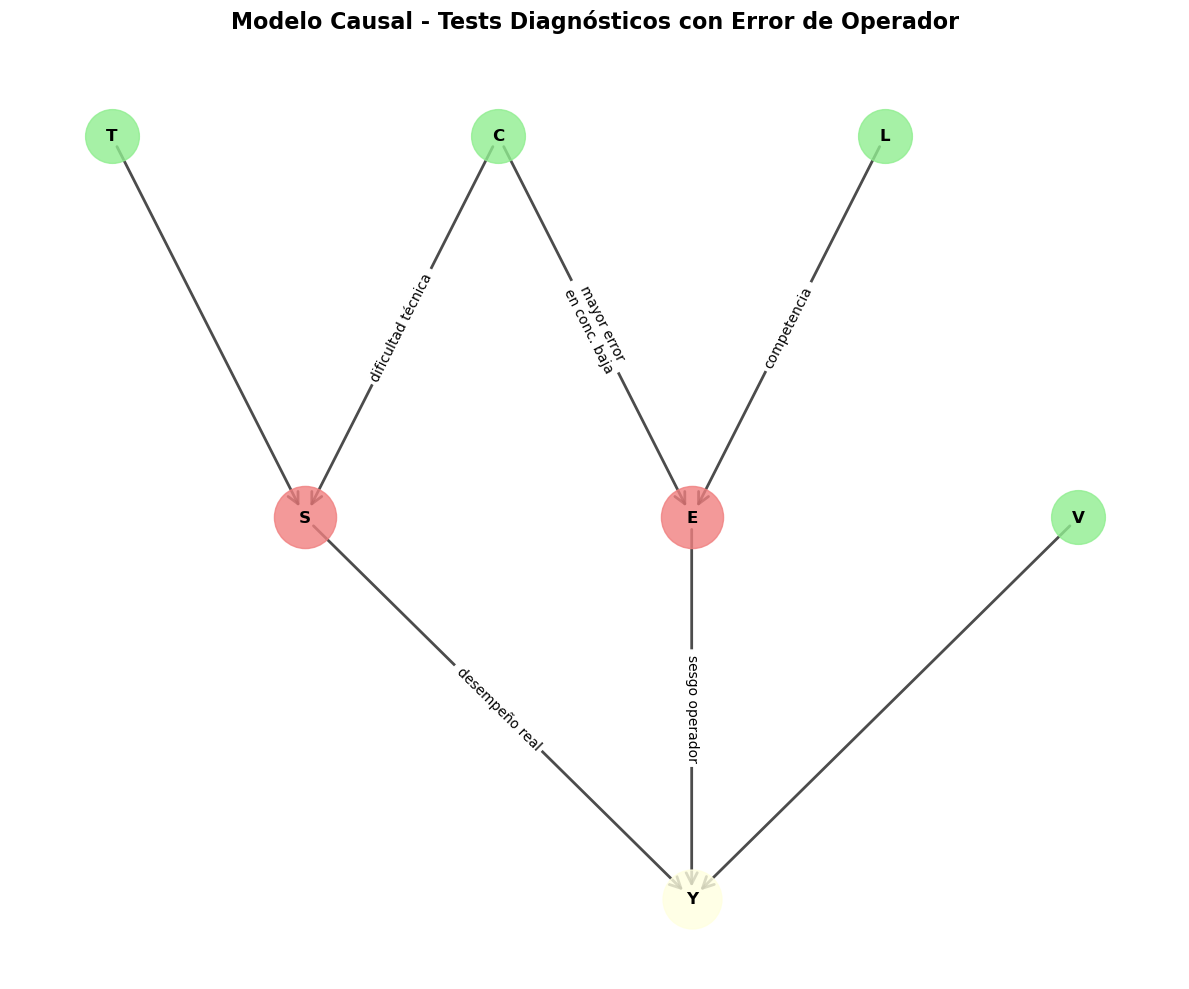

In [6]:
# Grafo causal
edge_list = [
    ("C", "S"),
    ("T", "S"),
    ("C", "E"),
    ("L", "E"),
    ("S", "Y"),
    ("E", "Y"),
    ("V", "Y")
]

node_props = {
    "V": {"color": "lightgreen", "size": 1500},
    "C": {"color": "lightgreen", "size": 1500},
    "T": {"color": "lightgreen", "size": 1500},
    "L": {"color": "lightgreen", "size": 1500},
    "S": {"color": "lightcoral", "size": 2000},
    "E": {"color": "lightcoral", "size": 2000},
    "Y": {"color": "lightyellow", "size": 1800}
}

edge_props = {
    ("C", "S"): {"label": "dificultad técnica"},
    ("C", "E"): {"label": "mayor error\nen conc. baja"},
    ("L", "E"): {"label": "competencia"},
    ("S", "Y"): {"label": "desempeño real"},
    ("E", "Y"): {"label": "sesgo operador"}
}

G, pos = draw_causal_graph(edge_list, graph_direction="TB", node_props=node_props, edge_props=edge_props, figsize=(12, 10))
plt.show()

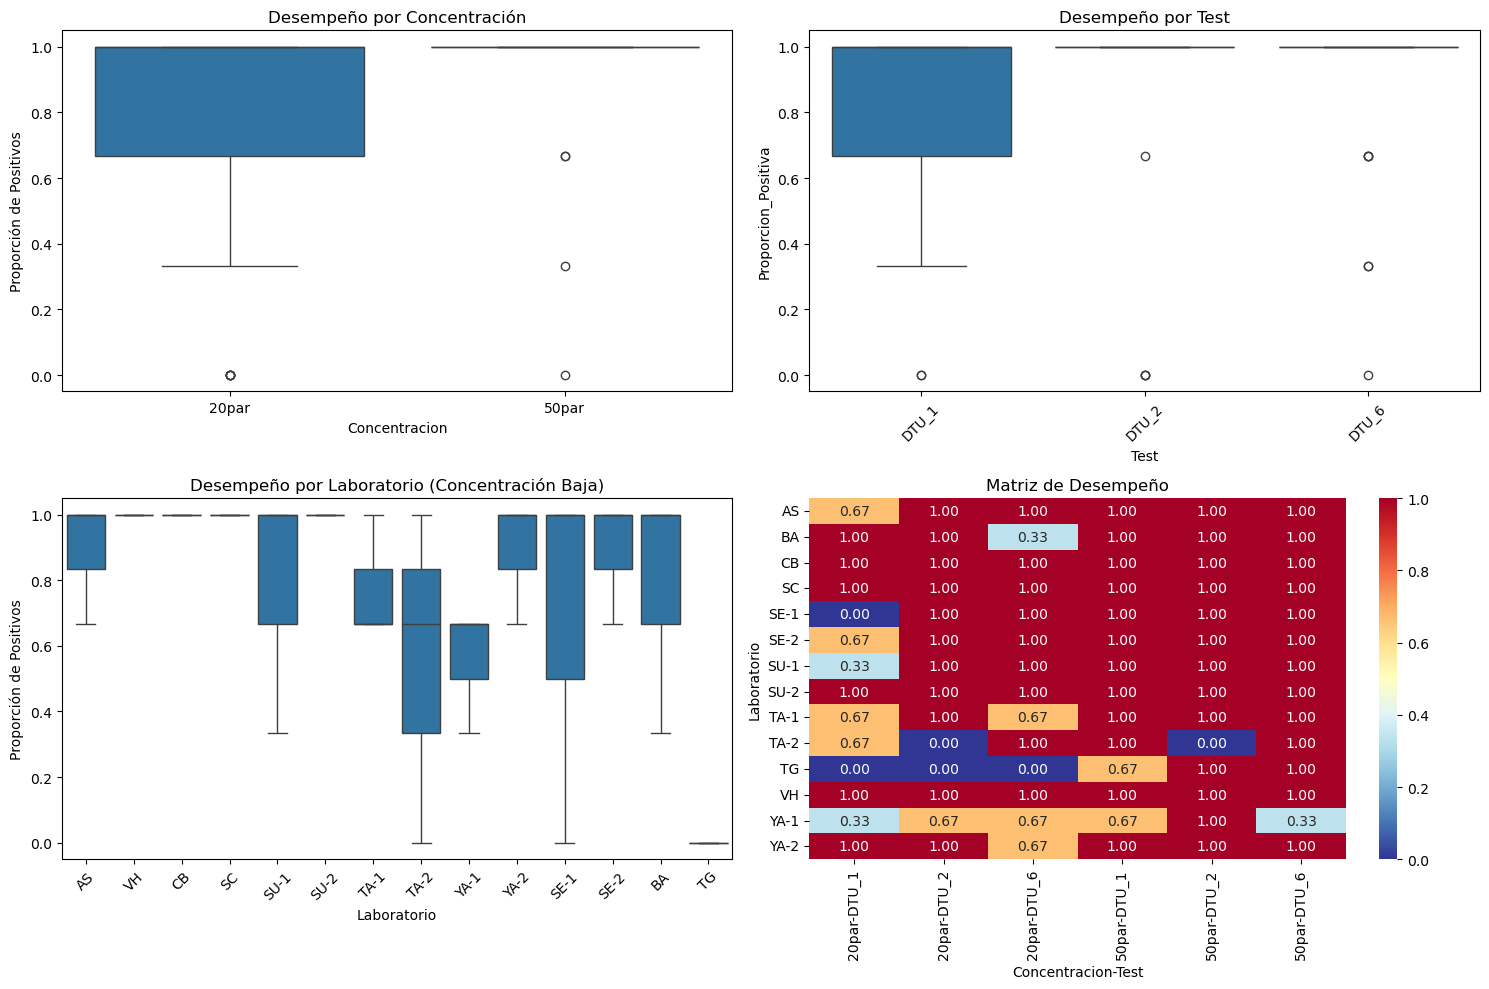

In [7]:
# Análisis exploratorio
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sns.boxplot(data=df_long, x='Concentracion', y='Proporcion_Positiva', ax=axes[0,0])
axes[0,0].set_title('Desempeño por Concentración')
axes[0,0].set_ylabel('Proporción de Positivos')

sns.boxplot(data=df_long, x='Test', y='Proporcion_Positiva', ax=axes[0,1])
axes[0,1].set_title('Desempeño por Test')
axes[0,1].tick_params(axis='x', rotation=45)

df_low = df_long[df_long['Concentracion_num'] == 20]
sns.boxplot(data=df_low, x='Laboratorio', y='Proporcion_Positiva', ax=axes[1,0])
axes[1,0].set_title('Desempeño por Laboratorio (Concentración Baja)')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_ylabel('Proporción de Positivos')

pivot_data = df_long.pivot_table(values='Proporcion_Positiva', index='Laboratorio', columns=['Concentracion', 'Test'], aggfunc='mean')
sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='RdYlBu_r', ax=axes[1,1])
axes[1,1].set_title('Matriz de Desempeño')

plt.tight_layout()
plt.show()

### 3.3 Inferencia Bayesiana

Priors seleccionados:
- Competencia laboratorio: Beta(3, 1.5)
- Sensibilidad base: Beta(8,2), Beta(12,2), Beta(10,2) para DTU1, DTU2, DTU6
- Efecto concentración: N(-1.0, 0.3) para baja, N(15.0, 0.1) para alta
- Efecto error: N(1.0, 0.5) para baja, N(-2.0, 0.2) para alta

In [8]:
# Preparación de datos para PyMC
labs = df_long['Laboratorio'].unique()
tests = df_long['Test'].unique()
concs = df_long['Concentracion_num'].unique()

lab_idx = pd.Categorical(df_long['Laboratorio'], categories=labs).codes
test_idx = pd.Categorical(df_long['Test'], categories=tests).codes
conc_idx = pd.Categorical(df_long['Concentracion_num'], categories=concs).codes

print(f"Laboratorios: {len(labs)} ({labs})")
print(f"Tests: {len(tests)} ({tests})")
print(f"Concentraciones: {len(concs)} ({concs})")
print(f"Observaciones totales: {len(df_long)}")

Laboratorios: 14 (['AS' 'VH' 'CB' 'SC' 'SU-1' 'SU-2' 'TA-1' 'TA-2' 'YA-1' 'YA-2' 'SE-1'
 'SE-2' 'BA' 'TG'])
Tests: 3 (['DTU_1' 'DTU_2' 'DTU_6'])
Concentraciones: 2 ([20 50])
Observaciones totales: 84


In [9]:
# Modelo Bayesiano
with pm.Model() as modelo_causal:
    # Priors
    competencia_lab = pm.Beta("competencia_lab", alpha=3, beta=1.5, shape=len(labs))
    sensibilidad_base = pm.Beta("sensibilidad_base", 
                               alpha=[8, 12, 10],
                               beta=[2, 2, 2],
                               shape=len(tests))

    efecto_concentracion = pm.Normal("efecto_concentracion", 
                                   mu=[-1.0, 2.0],
                                   sigma=[0.3, 0.2],
                                   shape=len(concs))

    # Sensibilidad real
    logit_sensibilidad_real = pm.Deterministic(name="logit_sensibilidad_real",var=pm.math.logit(sensibilidad_base[test_idx]) + efecto_concentracion[conc_idx])
    sensibilidad_real = pm.Deterministic(name="sensibilidad_real",var=pm.math.sigmoid(logit_sensibilidad_real))

    # Error del operador
    efecto_conc_error = pm.Normal("efecto_conc_error", 
                                mu=[1.0, -2.0],
                                sigma=[0.5, 0.2],
                                shape=len(concs))
    
    logit_prob_error = pm.Deterministic(name="logit_prob_error",var=pm.math.logit(1 - competencia_lab[lab_idx]) + efecto_conc_error[conc_idx])
    prob_error = pm.Deterministic(name="prob_error",var=pm.math.sigmoid(logit_prob_error))

    # Probabilidad observada
    prob_observada = pm.Deterministic(name="prob_observada",var=(1 - prob_error) * sensibilidad_real + prob_error * (1 - sensibilidad_real))

    y_obs = pm.Binomial("y_obs", n=df_long['n_muestras'].values, p=prob_observada, observed=df_long['n_positivos'].values)

    print("Iniciando muestreo MCMC...")
    idata = pm.sample(2000, tune=1000, chains=4, target_accept=0.95, return_inferencedata=True)

Iniciando muestreo MCMC...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [competencia_lab, sensibilidad_base, efecto_concentracion, efecto_conc_error]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


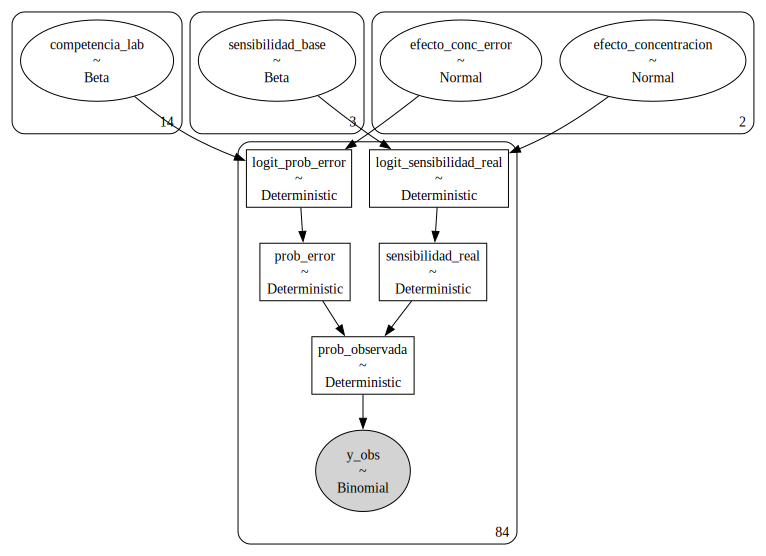

In [10]:
pm.model_to_graphviz(modelo_causal)

In [11]:
# Diagnóstico de convergencia
print("=== DIAGNÓSTICOS DE CONVERGENCIA ===")
summary = az.summary(idata)
print(summary[['mean', 'sd', 'hdi_3%', 'hdi_97%', 'r_hat', 'ess_bulk']])

max_rhat = summary['r_hat'].max()

=== DIAGNÓSTICOS DE CONVERGENCIA ===
                          mean     sd  hdi_3%  hdi_97%  r_hat  ess_bulk
efecto_concentracion[0] -0.702  0.286  -1.257   -0.176    1.0   12644.0
efecto_concentracion[1]  2.027  0.201   1.653    2.411    1.0   13776.0
efecto_conc_error[0]    -0.116  0.323  -0.725    0.481    1.0   10686.0
efecto_conc_error[1]    -2.032  0.186  -2.373   -1.685    1.0   13011.0
competencia_lab[0]       0.856  0.102   0.670    0.998    1.0    9932.0
...                        ...    ...     ...      ...    ...       ...
prob_observada[79]       0.966  0.022   0.925    0.995    1.0   12537.0
prob_observada[80]       0.951  0.033   0.892    0.996    1.0   10799.0
prob_observada[81]       0.968  0.022   0.929    0.997    1.0   11321.0
prob_observada[82]       0.955  0.028   0.905    0.993    1.0   11656.0
prob_observada[83]       0.767  0.090   0.600    0.923    1.0   14142.0

[441 rows x 6 columns]


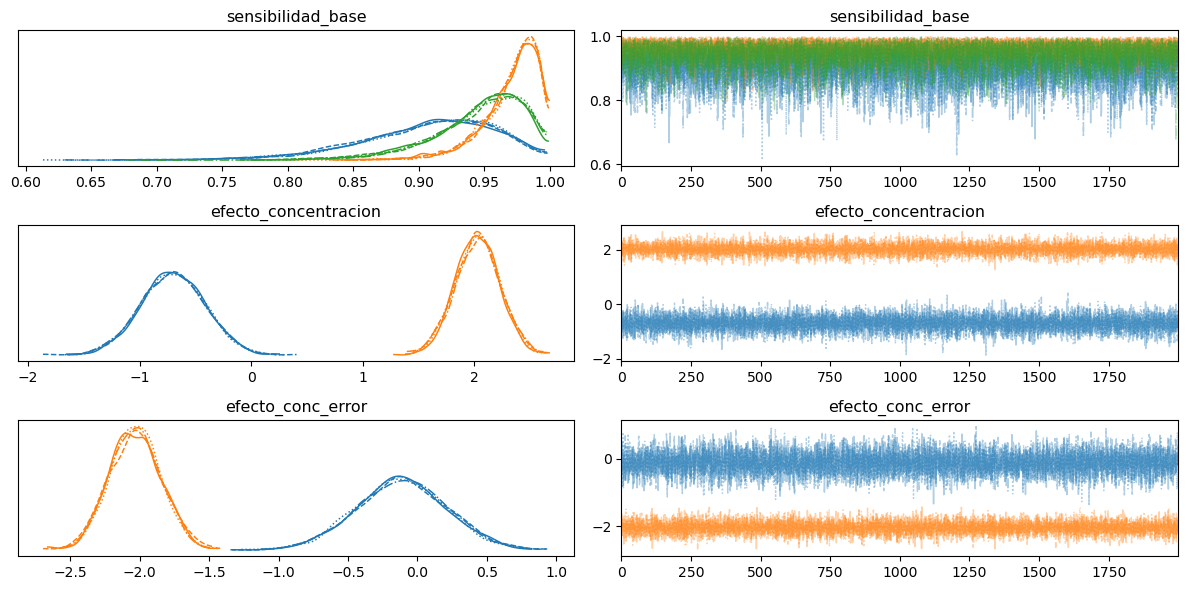

In [12]:
# Trazas de variables clave
az.plot_trace(idata, var_names=['sensibilidad_base', 'efecto_concentracion', 'efecto_conc_error'])
plt.tight_layout()
plt.show()

### 3.4 Análisis de Competencia de Operadores

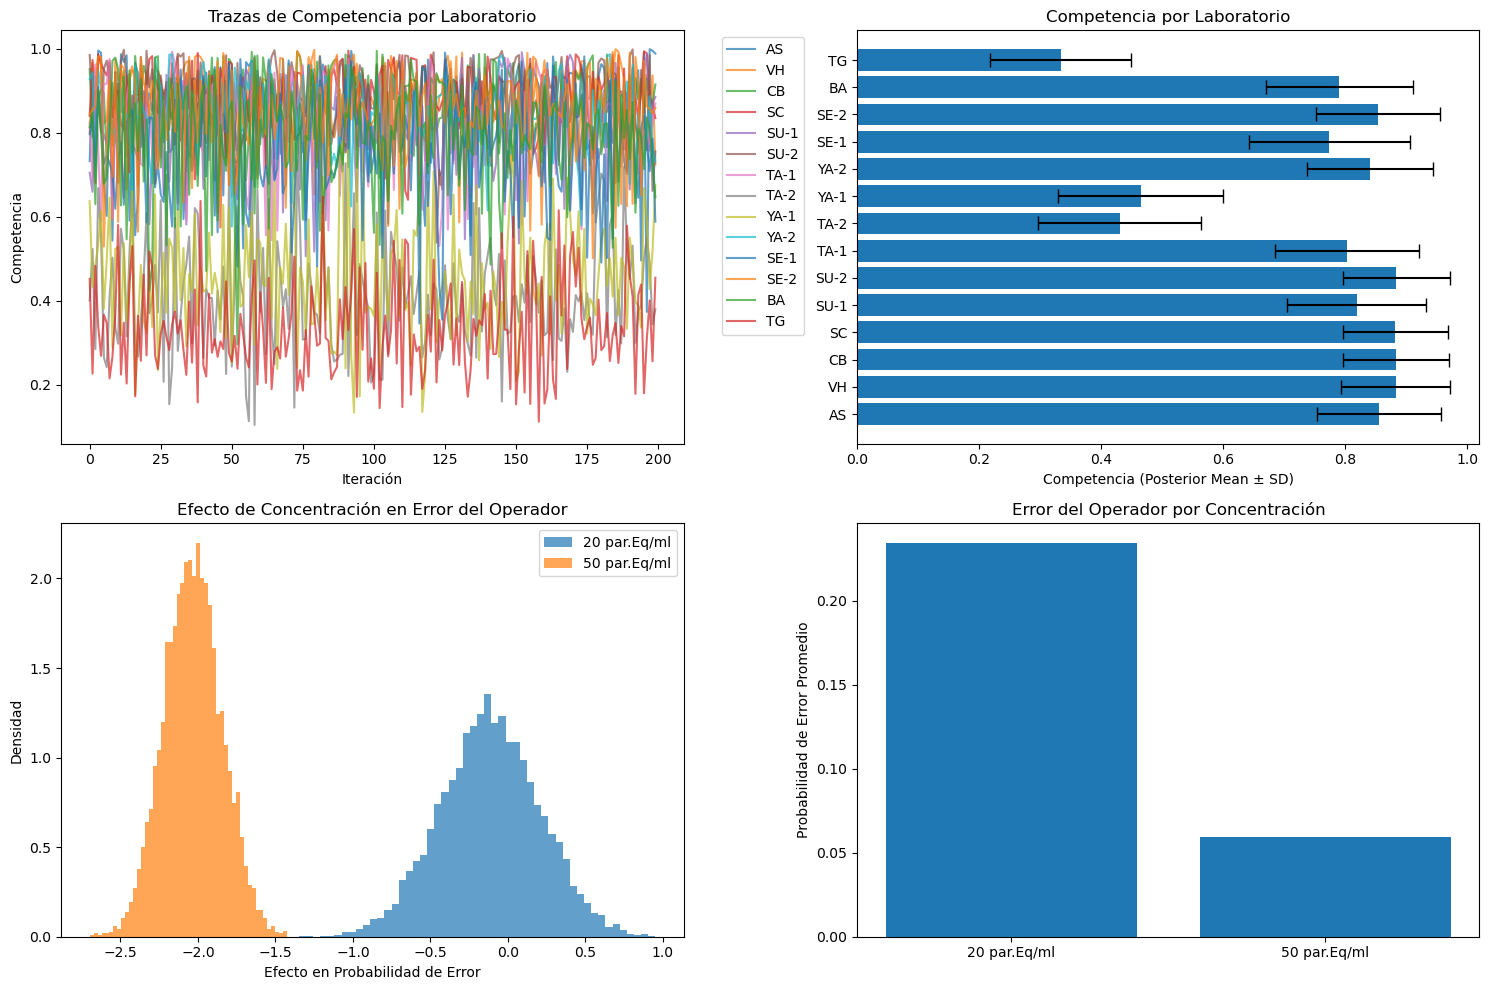

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Trazas de competencia
competencia_posterior = idata.posterior['competencia_lab']

for i, lab in enumerate(labs):
    lab_samples = competencia_posterior.sel(competencia_lab_dim_0=i).values.flatten()[:200]
    axes[0,0].plot(lab_samples, alpha=0.7, label=f'{lab}')
axes[0,0].set_title('Trazas de Competencia por Laboratorio')
axes[0,0].set_xlabel('Iteración')
axes[0,0].set_ylabel('Competencia')
axes[0,0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Estadísticas de competencia
competencia_mean = competencia_posterior.mean(dim=['chain', 'draw'])
competencia_std = competencia_posterior.std(dim=['chain', 'draw'])

y_pos = np.arange(len(labs))
axes[0,1].barh(y_pos, competencia_mean, xerr=competencia_std, capsize=5)
axes[0,1].set_yticks(y_pos)
axes[0,1].set_yticklabels(labs)
axes[0,1].set_xlabel('Competencia (Posterior Mean ± SD)')
axes[0,1].set_title('Competencia por Laboratorio')

# Efecto de concentración en error
efecto_error_posterior = idata.posterior['efecto_conc_error']
for i, conc in enumerate(concs):
    conc_samples = efecto_error_posterior.sel(efecto_conc_error_dim_0=i).values.flatten()
    axes[1,0].hist(conc_samples, bins=50, alpha=0.7, label=f'{conc} par.Eq/ml', density=True)
axes[1,0].set_xlabel('Efecto en Probabilidad de Error')
axes[1,0].set_ylabel('Densidad')
axes[1,0].set_title('Efecto de Concentración en Error del Operador')
axes[1,0].legend()

# Error promedio por concentración
competencia_samples = idata.posterior['competencia_lab']
efecto_error_samples = idata.posterior['efecto_conc_error']

prob_error_by_conc = {}
for conc_i, conc in enumerate(concs):
    errors = []
    for lab_i in range(len(labs)):
        lab_comp = competencia_samples.sel(competencia_lab_dim_0=lab_i).values.flatten()
        conc_effect = efecto_error_samples.sel(efecto_conc_error_dim_0=conc_i).values.flatten()
        
        logit_error = np.log((1 - lab_comp) / lab_comp) + conc_effect
        prob_error = 1 / (1 + np.exp(-logit_error))
        errors.append(prob_error.mean())
    prob_error_by_conc[conc] = np.mean(errors)

conc_labels = [f'{c} par.Eq/ml' for c in concs]
axes[1,1].bar(conc_labels, list(prob_error_by_conc.values()))
axes[1,1].set_ylabel('Probabilidad de Error Promedio')
axes[1,1].set_title('Error del Operador por Concentración')

plt.tight_layout()
plt.show()

### 3.5 Análisis de Desempeño de Tests

In [14]:
# Extracción de posteriores para análisis de sensibilidad
sens_base_posterior = idata.posterior['sensibilidad_base']
efecto_conc_posterior = idata.posterior['efecto_concentracion']

sensibilidades = {}
for test_i, test in enumerate(tests):
    sensibilidades[test] = {}
    for conc_i, conc in enumerate(concs):
        test_sens = sens_base_posterior.sel(sensibilidad_base_dim_0=test_i).values.flatten()
        conc_effect = efecto_conc_posterior.sel(efecto_concentracion_dim_0=conc_i).values.flatten()
        
        logit_sens = np.log(test_sens / (1 - test_sens)) + conc_effect
        sens = 1 / (1 + np.exp(-logit_sens))
        sensibilidades[test][conc] = sens

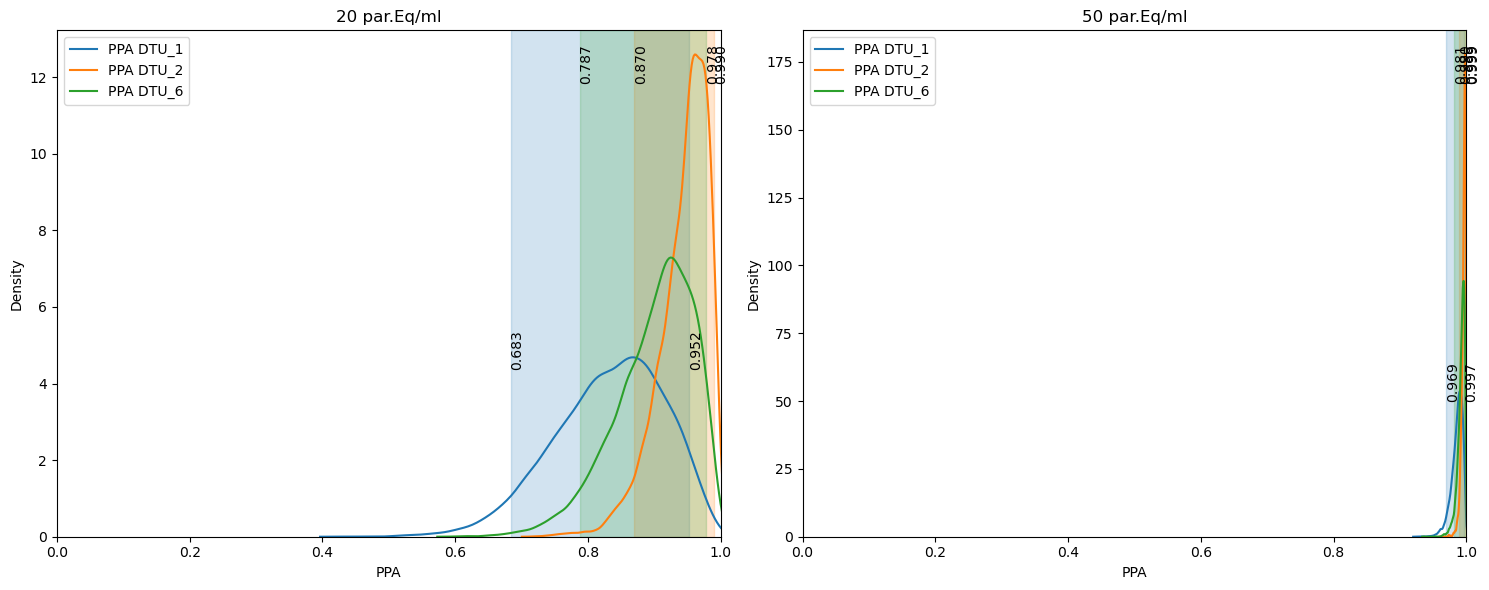

In [19]:
# Visualización de sensibilidad por concentración
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Baja concentración (20 par.Eq/ml)
for test_i, test in enumerate(tests):
    sens_samples = sensibilidades[test][20]
    sns.kdeplot(sens_samples, ax=ax1, label=f'PPA {test}')
    
    hdi_low, hdi_high = np.percentile(sens_samples, [5, 95])
    ax1.axvspan(hdi_low, hdi_high, alpha=0.2, color=f'C{test_i}')
    ax1.text(hdi_low, ax1.get_ylim()[1]*0.9, f'{hdi_low:.3f}', rotation=90)
    ax1.text(hdi_high, ax1.get_ylim()[1]*0.9, f'{hdi_high:.3f}', rotation=90)

ax1.set_xlim(0, 1)
ax1.set_title('20 par.Eq/ml')
ax1.set_xlabel('PPA')
ax1.set_ylabel('Density')
ax1.legend()

# Alta concentración (50 par.Eq/ml)
for test_i, test in enumerate(tests):
    sens_samples = sensibilidades[test][50]
    sns.kdeplot(sens_samples, ax=ax2, label=f'PPA {test}')
    
    hdi_low, hdi_high = np.percentile(sens_samples, [5, 95])
    ax2.axvspan(hdi_low, hdi_high, alpha=0.2, color=f'C{test_i}')
    ax2.text(hdi_low, ax2.get_ylim()[1]*0.9, f'{hdi_low:.3f}', rotation=90)
    ax2.text(hdi_high, ax2.get_ylim()[1]*0.9, f'{hdi_high:.3f}', rotation=90)

ax2.set_xlim(0, 1)
ax2.set_title('50 par.Eq/ml')
ax2.set_xlabel('PPA')
ax2.set_ylabel('Density')
ax2.legend()

plt.tight_layout()
plt.show()

In [15]:
print("\n=== HDI INTERVALS (5% - 95%) ===")
print("\n20 par.Eq/ml:")
for test in tests:
    hdi_low, hdi_high = np.percentile(sensibilidades[test][20], [5, 95])
    print(f"PPA {test}: {hdi_low:.3f} - {hdi_high:.3f}")

print("\n50 par.Eq/ml:")
for test in tests:
    hdi_low, hdi_high = np.percentile(sensibilidades[test][50], [5, 95])
    print(f"PPA {test}: {hdi_low:.3f} - {hdi_high:.3f}")


=== HDI INTERVALS (5% - 95%) ===

20 par.Eq/ml:
PPA DTU_1: 0.686 - 0.952
PPA DTU_2: 0.868 - 0.990
PPA DTU_6: 0.788 - 0.977

50 par.Eq/ml:
PPA DTU_1: 0.968 - 0.997
PPA DTU_2: 0.989 - 0.999
PPA DTU_6: 0.981 - 0.999


In [16]:
print("=== COMPARACIONES ENTRE TESTS (CONCENTRACIÓN BAJA: 20 par.Eq/ml) ===\n")

conc_baja_idx = 0
sens_baja = {test: sensibilidades[test][concs[conc_baja_idx]] for test in tests}

comparaciones = [('DTU_1', 'DTU_2'), ('DTU_1', 'DTU_6'), ('DTU_2', 'DTU_6')]

for test1, test2 in comparaciones:
    if test1 in sens_baja and test2 in sens_baja:
        prob_superior = (sens_baja[test1] > sens_baja[test2]).mean()
        print(f"P({test1} > {test2} | Datos) = {prob_superior:.4f}")

=== COMPARACIONES ENTRE TESTS (CONCENTRACIÓN BAJA: 20 par.Eq/ml) ===

P(DTU_1 > DTU_2 | Datos) = 0.0970
P(DTU_1 > DTU_6 | Datos) = 0.2452
P(DTU_2 > DTU_6 | Datos) = 0.7426


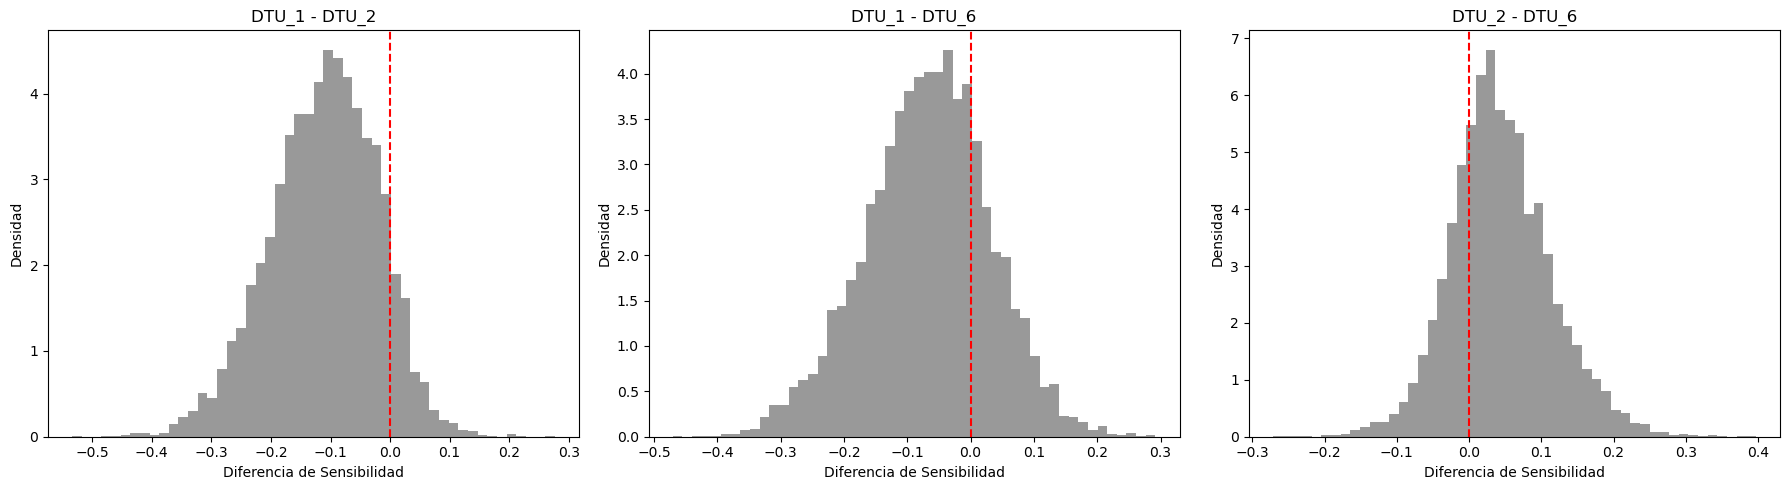

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (test1, test2) in enumerate(comparaciones):
    diff = sens_baja[test1] - sens_baja[test2]
    axes[i].hist(diff, bins=50, color='gray', alpha=0.8, density=True)
    axes[i].axvline(0, color='red', linestyle='--')
    axes[i].set_title(f'{test1} - {test2}')
    axes[i].set_xlabel('Diferencia de Sensibilidad')
    axes[i].set_ylabel('Densidad')

plt.tight_layout()
plt.show()